In [1]:
# dataframe and plotting
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler


In [2]:
# oversampling techniques to handle imbalanced data
from imblearn.over_sampling import RandomOverSampler as ROS
from imblearn.under_sampling import RandomUnderSampler as RUS
from collections import Counter

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

In [4]:
# Load files into a pandas dataframe
train = pd.read_csv('Train.csv')

In [5]:
test = pd.read_csv('Test.csv')
_test = test.copy()

In [6]:
_train = train.copy()
# Let’s observe the shape of our datasets.
print('train data shape :', train.shape)
print('test data shape :', test.shape)

## The following split was not necessary
features = train.drop('bank_account', axis=1)
labels = train['bank_account']
countries = list(features['country'].unique())

_features = features.copy()
_features = _features.drop(['uniqueid'], axis=1)

train data shape : (23524, 13)
test data shape : (10086, 12)


In [7]:
_train_ = pd.concat([_features, labels], axis=1)

In [8]:
_train_.columns

Index(['country', 'year', 'location_type', 'cellphone_access',
       'household_size', 'age_of_respondent', 'gender_of_respondent',
       'relationship_with_head', 'marital_status', 'education_level',
       'job_type', 'bank_account'],
      dtype='object')

In [9]:
_train_.head()

,country,year,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type,bank_account
0,Kenya,2018,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed,Yes
1,Kenya,2018,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent,No
2,Kenya,2018,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed,Yes
3,Kenya,2018,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private,No
4,Kenya,2018,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed,No


In [10]:
# add weight to bank_account
_train_['weight_control'] = np.where(_train_['bank_account'] == 'Yes', 1.5, .5)

In [11]:
categorical_columns = _train_.select_dtypes(include=['object']).columns.drop(['bank_account'])
non_categorical_columns = _train_.select_dtypes(exclude=['object']).columns.drop(['weight_control'])


NUMERIC_FEATURE_NAMES  = list(non_categorical_columns)
CATEGORICAL_FEATURES_WITH_VOCABULARY = {}
for feature in categorical_columns:
    unique_values = sorted(list(_train_[feature].unique()))
    CATEGORICAL_FEATURES_WITH_VOCABULARY[feature] = unique_values

# Print the dictionary
CATEGORICAL_FEATURES_WITH_VOCABULARY

{'country': ['Kenya', 'Rwanda', 'Tanzania', 'Uganda'],
 'location_type': ['Rural', 'Urban'],
 'cellphone_access': ['No', 'Yes'],
 'gender_of_respondent': ['Female', 'Male'],
 'relationship_with_head': ['Child',
  'Head of Household',
  'Other non-relatives',
  'Other relative',
  'Parent',
  'Spouse'],
 'marital_status': ['Divorced/Seperated',
  'Dont know',
  'Married/Living together',
  'Single/Never Married',
  'Widowed'],
 'education_level': ['No formal education',
  'Other/Dont know/RTA',
  'Primary education',
  'Secondary education',
  'Tertiary education',
  'Vocational/Specialised training'],
 'job_type': ['Dont Know/Refuse to answer',
  'Farming and Fishing',
  'Formally employed Government',
  'Formally employed Private',
  'Government Dependent',
  'Informally employed',
  'No Income',
  'Other Income',
  'Remittance Dependent',
  'Self employed']}

In [12]:
# name of columns to be used as instance weight
CATEGORICAL_FEATURE_NAMES = list(CATEGORICAL_FEATURES_WITH_VOCABULARY.keys())
print(CATEGORICAL_FEATURE_NAMES)

FEATURE_NAMES = NUMERIC_FEATURE_NAMES + CATEGORICAL_FEATURE_NAMES

# Name of the column to be used as instances weight.
WEIGHT_COLUMN_NAME = "weight_control"

FEATURE_NAMES = NUMERIC_FEATURE_NAMES + CATEGORICAL_FEATURE_NAMES
# A list of column default values for each feature.
COLUMN_DEFAULTS = _train_.columns.to_series().tolist()
# The name of the target feature.
TARGET_FEATURE_NAME = "bank_account"
# A list of the labels of the target features.
TARGET_LABELS = ['No', 'Yes']

['country', 'location_type', 'cellphone_access', 'gender_of_respondent', 'relationship_with_head', 'marital_status', 'education_level', 'job_type']


In [13]:
_train_df, _test_df = train_test_split(_train_, test_size=.2, stratify=_train_['bank_account'], shuffle='true')

In [14]:
import keras
from keras import layers
import tensorflow as tf

import math
import numpy as np
from tensorflow import data as tf_data
from functools import partial

In [15]:
# model parameters

LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
DROPOUT_RATE = 0.2
BATCH_SIZE = 265
NUM_EPOCHS = 50

NUM_TRANSFORMER_BLOCKS = 5  # Number of transformer blocks.
NUM_HEADS = 6  # Number of attention heads.
EMBEDDING_DIMS = 32  # Embedding dimensions of the categorical features.
MLP_HIDDEN_UNITS_FACTORS = [
    4,
    2,
]  # MLP hidden layer units, as factors of the number of inputs.
NUM_MLP_BLOCKS = 5  # Number of MLP blocks in the baseline model.

In [16]:
target_label_lookup = layers.StringLookup(
    vocabulary=TARGET_LABELS, mask_token=None, num_oov_indices=0
)


def prepare_example(features, target, weights):
    target_index = target_label_lookup(target)
    return features, target_index, weights



lookup_dict = {}
for feature_name in CATEGORICAL_FEATURE_NAMES:
    vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
    # Create a lookup to convert a string values to an integer indices.
    # Since we are not using a mask token, nor expecting any out of vocabulary
    # (oov) token, we set mask_token to None and num_oov_indices to 0.
    lookup = layers.StringLookup(
        vocabulary=vocabulary, mask_token=None, num_oov_indices=0
    )
    lookup_dict[feature_name] = lookup


def encode_categorical(batch_x, batch_y, weights):
    for feature_name in CATEGORICAL_FEATURE_NAMES:
        batch_x[feature_name] = tf.cast(lookup_dict[feature_name](batch_x[feature_name]), tf.int64)

    return batch_x, batch_y, weights


def get_dataset_from_dataframe(dataframe, batch_size=128, shuffle=False):
    dataset = (
        tf_data.Dataset.from_tensor_slices(dict(dataframe))
        .shuffle(buffer_size=len(dataframe), seed=42, reshuffle_each_iteration=True)
        .batch(batch_size)
        .map(lambda x: prepare_example(x, x[TARGET_FEATURE_NAME], x[WEIGHT_COLUMN_NAME]),
             num_parallel_calls=tf_data.AUTOTUNE, deterministic=False)
        .map(encode_categorical)
    )
    return dataset.cache()

/usr/local/lib/python3.10/dist-packages/numpy/core/numeric.py:2463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


In [17]:
# preview lookup dict
lookup_dict

{'country': <keras.src.layers.preprocessing.string_lookup.StringLookup at 0x7a0737508460>,
 'location_type': <keras.src.layers.preprocessing.string_lookup.StringLookup at 0x7a07375086a0>,
 'cellphone_access': <keras.src.layers.preprocessing.string_lookup.StringLookup at 0x7a0737508cd0>,
 'gender_of_respondent': <keras.src.layers.preprocessing.string_lookup.StringLookup at 0x7a0737509300>,
 'relationship_with_head': <keras.src.layers.preprocessing.string_lookup.StringLookup at 0x7a0737509930>,
 'marital_status': <keras.src.layers.preprocessing.string_lookup.StringLookup at 0x7a0737509f90>,
 'education_level': <keras.src.layers.preprocessing.string_lookup.StringLookup at 0x7a073750a5f0>,
 'job_type': <keras.src.layers.preprocessing.string_lookup.StringLookup at 0x7a073750ac50>}

In [18]:
def run_experiment(
    model,
    train_data,
    test_data,
    num_epochs,
    learning_rate,
    weight_decay,
    batch_size,
):
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.BinaryCrossentropy(),
        metrics=[keras.metrics.BinaryAccuracy(name="accuracy")],
        weighted_metrics=[]
    )

    train_dataset = get_dataset_from_dataframe(train_data, batch_size, shuffle=True)
    validation_dataset = get_dataset_from_dataframe(test_data, batch_size)

    print("Start training the model...")
    history = model.fit(
        train_dataset, epochs=num_epochs, validation_data=validation_dataset
    )
    print("Model training finished")

    _, accuracy = model.evaluate(validation_dataset, verbose=0)

    print(f"Validation accuracy: {round(accuracy * 100, 2)}%")

    return history

In [19]:
def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        if feature_name in NUMERIC_FEATURE_NAMES:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype="float32"
            )
        else:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype="float32"
            )
    return inputs

In [20]:
def encode_inputs(inputs, embedding_dims):
    encoded_categorical_feature_list = []
    numerical_feature_list = []

    for feature_name in inputs:
        if feature_name in CATEGORICAL_FEATURE_NAMES:
            vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
            # Create a lookup to convert a string values to an integer indices.
            # Since we are not using a mask token, nor expecting any out of vocabulary
            # (oov) token, we set mask_token to None and num_oov_indices to 0.

            # Convert the string input values into integer indices.

            # Create an embedding layer with the specified dimensions.
            embedding = layers.Embedding(
                input_dim=len(vocabulary), output_dim=embedding_dims
            )

            # Convert the index values to embedding representations.
            encoded_categorical_feature = embedding(inputs[feature_name])
            encoded_categorical_feature_list.append(encoded_categorical_feature)

        else:
            # Use the numerical features as-is.
            numerical_feature = tf.expand_dims(inputs[feature_name], axis=-1)
            numerical_feature_list.append(numerical_feature)


    return encoded_categorical_feature_list, numerical_feature_list

In [21]:
def create_mlp(hidden_units, dropout_rate, activation, normalization_layer, name=None):
    mlp_layers = []
    for units in hidden_units:
        mlp_layers.append(normalization_layer()),
        mlp_layers.append(layers.Dense(units, activation=activation))
        mlp_layers.append(layers.Dropout(dropout_rate))

    return keras.Sequential(mlp_layers, name=name)

In [22]:
def create_baseline_model(
    embedding_dims, num_mlp_blocks, mlp_hidden_units_factors, dropout_rate
):
    # Create model inputs.
    inputs = create_model_inputs()
    # encode features.
    encoded_categorical_feature_list, numerical_feature_list = encode_inputs(
        inputs, embedding_dims
    )
    # Concatenate all features.
    features = layers.concatenate(
        encoded_categorical_feature_list + numerical_feature_list
    )
    # Compute Feedforward layer units.
    feedforward_units = [features.shape[-1]]

    # Create several feedforwad layers with skip connections.
    for layer_idx in range(num_mlp_blocks):
        features = create_mlp(
            hidden_units=feedforward_units,
            dropout_rate=dropout_rate,
            activation=keras.activations.gelu,
            normalization_layer=layers.LayerNormalization,
            name=f"feedforward_{layer_idx}",
        )(features)

    # Compute MLP hidden_units.
    mlp_hidden_units = [
        factor * features.shape[-1] for factor in mlp_hidden_units_factors
    ]
    # Create final MLP.
    features = create_mlp(
        hidden_units=mlp_hidden_units,
        dropout_rate=dropout_rate,
        activation=keras.activations.selu,
        normalization_layer=layers.BatchNormalization,
        name="MLP",
    )(features)

    # Add a sigmoid as a binary classifer.
    outputs = layers.Dense(units=1, activation="sigmoid", name="sigmoid")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)


    return model

In [23]:
baseline_model = create_baseline_model(
    embedding_dims=EMBEDDING_DIMS,
    num_mlp_blocks=NUM_MLP_BLOCKS,
    mlp_hidden_units_factors=MLP_HIDDEN_UNITS_FACTORS,
    dropout_rate=DROPOUT_RATE,
)

Total model weights: 1152699


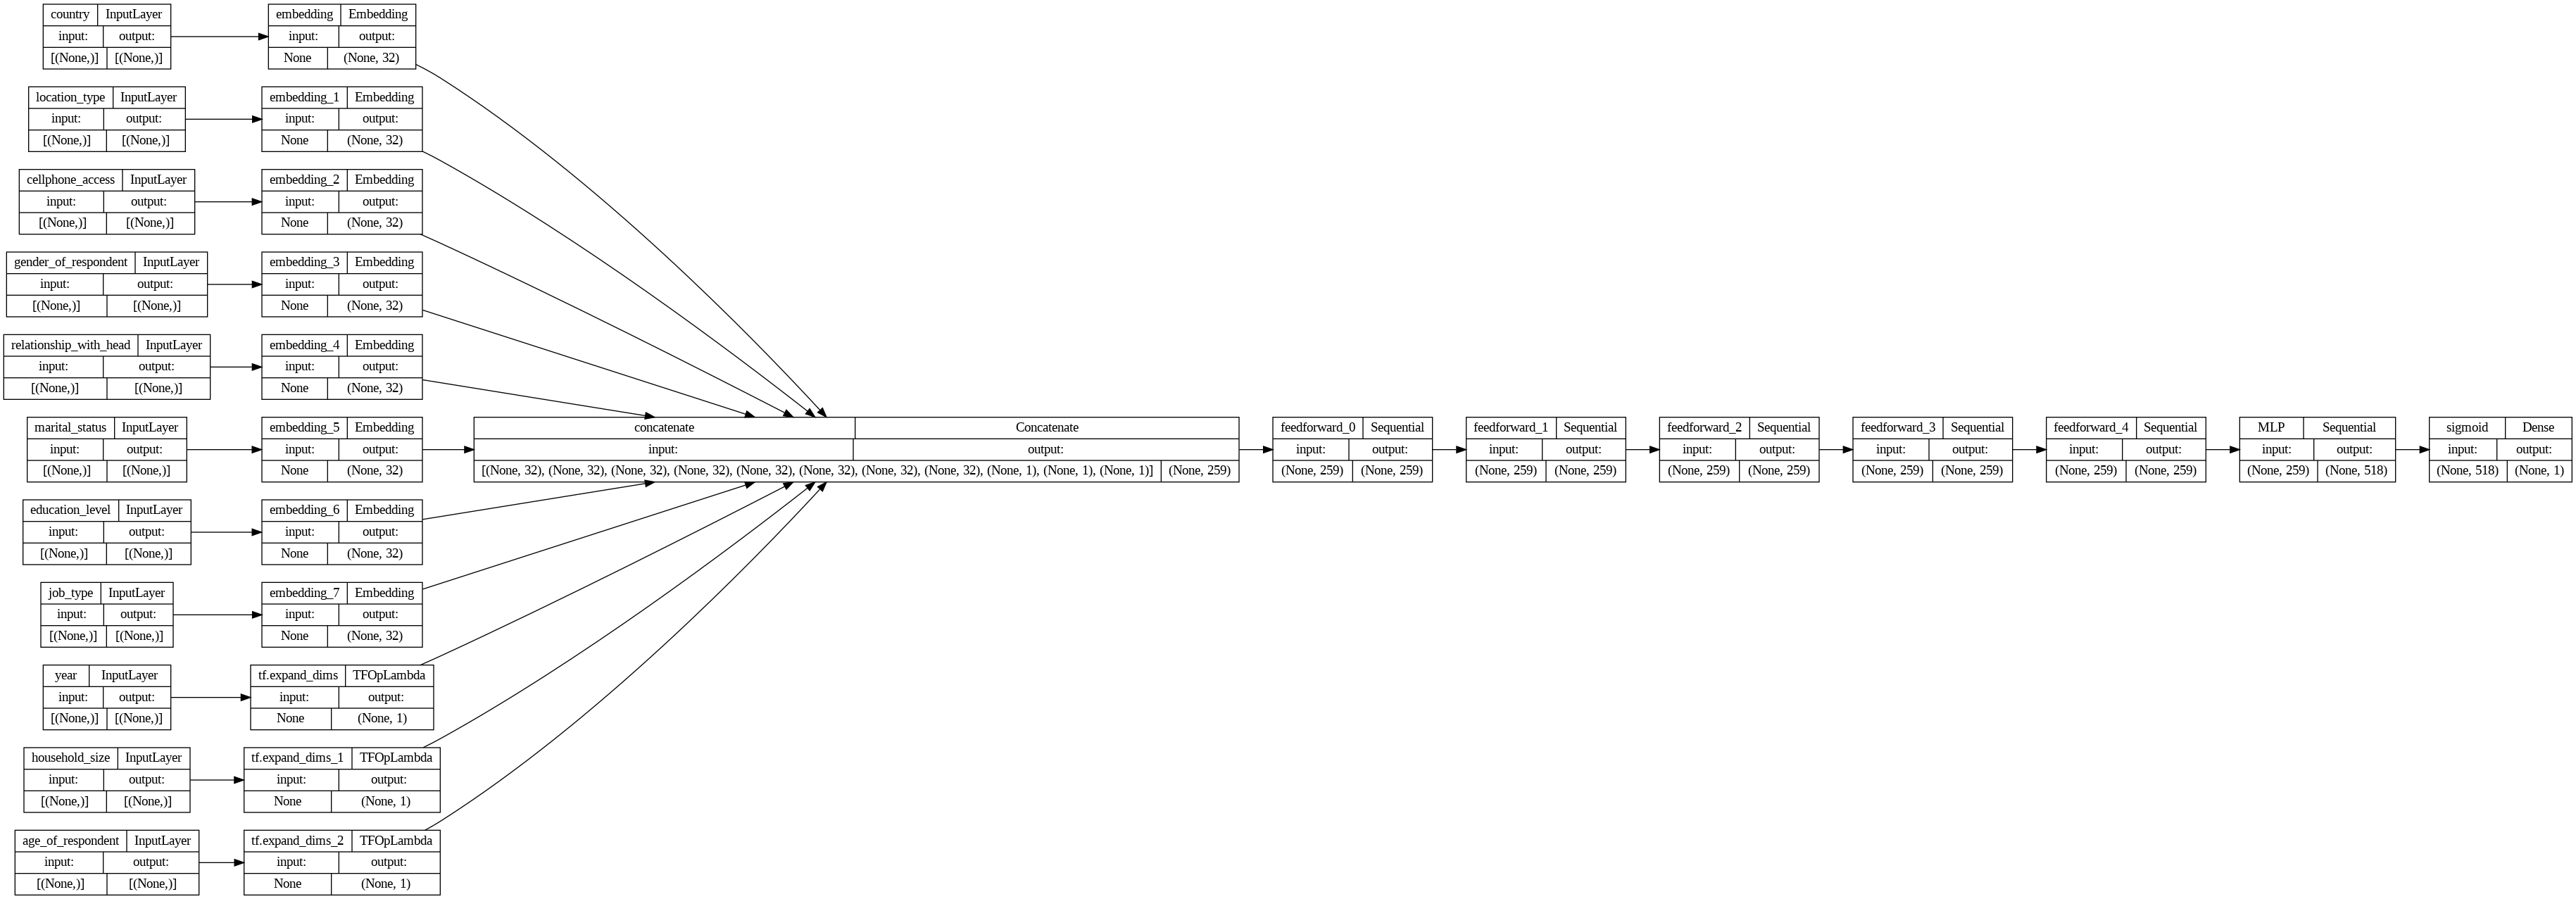

In [24]:
print("Total model weights:", baseline_model.count_params())
keras.utils.plot_model(baseline_model, show_shapes=True, rankdir="LR")

In [25]:
history = run_experiment(
    model=baseline_model,
    train_data=_train_df,
    test_data=_test_df,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    batch_size=BATCH_SIZE,
)

Start training the model...
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['bank_account', 'weight_control'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


72/72 [==============================] - 16s 42ms/step - loss: 0.5877 - accuracy: 0.6480 - val_loss: 0.4221 - val_accuracy: 0.8593
Epoch 2/50
72/72 [==============================] - 1s 15ms/step - loss: 0.5231 - accuracy: 0.6811 - val_loss: 0.4061 - val_accuracy: 0.8593
Epoch 3/50
72/72 [==============================] - 1s 14ms/step - loss: 0.4670 - accuracy: 0.7156 - val_loss: 0.4877 - val_accuracy: 0.1407
Epoch 4/50
72/72 [==============================] - 1s 15ms/step - loss: 0.4363 - accuracy: 0.7614 - val_loss: 0.4062 - val_accuracy: 0.8593
Epoch 5/50
72/72 [==============================] - 1s 15ms/step - loss: 0.4305 - accuracy: 0.7791 - val_loss: 0.4190 - val_accuracy: 0.8593
Epoch 6/50
72/72 [==============================] - 1s 16ms/step - loss: 0.4218 - accuracy: 0.8021 - val_loss: 0.4172 - val_accuracy: 0.8593
Epoch 7/50
72/72 [==============================] - 2s 22ms/step - loss: 0.4194 - accuracy: 0.8132 - val_loss: 0.4183 - val_accuracy: 0.8593
Epoch 8/50
72/72 [=====

In [26]:
def create_tabtransformer_classifier(
    num_transformer_blocks,
    num_heads,
    embedding_dims,
    mlp_hidden_units_factors,
    dropout_rate,
    use_column_embedding=False,
):
    # Create model inputs.
    inputs = create_model_inputs()
    # encode features.
    encoded_categorical_feature_list, numerical_feature_list = encode_inputs(
        inputs, embedding_dims
    )
    # Stack categorical feature embeddings for the Tansformer.
    encoded_categorical_features = tf.stack(encoded_categorical_feature_list, axis=1)
    # Concatenate numerical features.
    numerical_features = layers.concatenate(numerical_feature_list)

    # Add column embedding to categorical feature embeddings.
    if use_column_embedding:
      # Calculate number of columns
      num_columns = tf.shape(encoded_categorical_features)[1]

      # Define column embedding layer
      column_embedding = layers.Embedding(
          input_dim=num_columns, output_dim=embedding_dims
      )

      # Generate column indices (using tf.range instead of ops.arange)
      column_indices = tf.range(start=0, limit=num_columns, dtype=tf.int32)

      # Add column embedding to categorical features
      encoded_categorical_features = encoded_categorical_features + column_embedding(column_indices)


    # Create multiple layers of the Transformer block.
    for block_idx in range(num_transformer_blocks):
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dims,
            dropout=dropout_rate,
            name=f"multihead_attention_{block_idx}",
        )(encoded_categorical_features, encoded_categorical_features)
        # Skip connection 1.
        x = layers.Add(name=f"skip_connection1_{block_idx}")(
            [attention_output, encoded_categorical_features]
        )
        # Layer normalization 1.
        x = layers.LayerNormalization(name=f"layer_norm1_{block_idx}", epsilon=1e-6)(x)
        # Feedforward.
        feedforward_output = create_mlp(
            hidden_units=[embedding_dims],
            dropout_rate=dropout_rate,
            activation=keras.activations.gelu,
            normalization_layer=partial(
                layers.LayerNormalization, epsilon=1e-6
            ),  # using partial to provide keyword arguments before initialization
            name=f"feedforward_{block_idx}",
        )(x)
        # Skip connection 2.
        x = layers.Add(name=f"skip_connection2_{block_idx}")([feedforward_output, x])
        # Layer normalization 2.
        encoded_categorical_features = layers.LayerNormalization(
            name=f"layer_norm2_{block_idx}", epsilon=1e-6
        )(x)

    # Flatten the "contextualized" embeddings of the categorical features.
    categorical_features = layers.Flatten()(encoded_categorical_features)
    # Apply layer normalization to the numerical features.
    numerical_features = layers.LayerNormalization(epsilon=1e-6)(numerical_features)
    # Prepare the input for the final MLP block.
    features = layers.concatenate([categorical_features, numerical_features])

    # Compute MLP hidden_units.
    mlp_hidden_units = [
        factor * features.shape[-1] for factor in mlp_hidden_units_factors
    ]
    # Create final MLP.
    features = create_mlp(
        hidden_units=mlp_hidden_units,
        dropout_rate=dropout_rate,
        activation=keras.activations.selu,
        normalization_layer=layers.BatchNormalization,
        name="MLP",
    )(features)

    # Add a sigmoid as a binary classifer.
    outputs = layers.Dense(units=1, activation="sigmoid", name="sigmoid")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


Total model weights: 945575


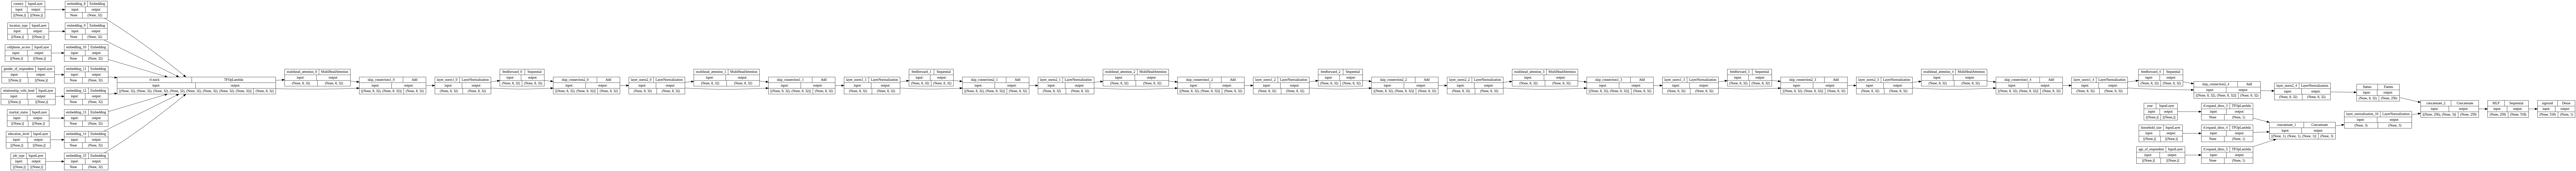

In [27]:
tabtransformer_model = create_tabtransformer_classifier(
    num_transformer_blocks=NUM_TRANSFORMER_BLOCKS,
    num_heads=NUM_HEADS,
    embedding_dims=EMBEDDING_DIMS,
    mlp_hidden_units_factors=MLP_HIDDEN_UNITS_FACTORS,
    dropout_rate=DROPOUT_RATE,
)

print("Total model weights:", tabtransformer_model.count_params())
keras.utils.plot_model(tabtransformer_model, show_shapes=True, rankdir="LR")

In [28]:
history = run_experiment(
    model=tabtransformer_model,
    train_data=_train_df,
    test_data=_test_df,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    batch_size=BATCH_SIZE,
)

Start training the model...
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['bank_account', 'weight_control'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


72/72 [==============================] - 23s 63ms/step - loss: 0.4400 - accuracy: 0.7562 - val_loss: 0.3554 - val_accuracy: 0.7943
Epoch 2/50
72/72 [==============================] - 2s 34ms/step - loss: 0.4249 - accuracy: 0.7804 - val_loss: 0.3357 - val_accuracy: 0.8380
Epoch 3/50
72/72 [==============================] - 3s 46ms/step - loss: 0.3519 - accuracy: 0.8029 - val_loss: 0.3134 - val_accuracy: 0.8612
Epoch 4/50
72/72 [==============================] - 3s 37ms/step - loss: 0.3368 - accuracy: 0.8038 - val_loss: 0.3757 - val_accuracy: 0.8818
Epoch 5/50
72/72 [==============================] - 2s 34ms/step - loss: 0.3108 - accuracy: 0.8234 - val_loss: 0.3248 - val_accuracy: 0.8825
Epoch 6/50
72/72 [==============================] - 3s 36ms/step - loss: 0.2952 - accuracy: 0.8351 - val_loss: 0.2897 - val_accuracy: 0.8746
Epoch 7/50
72/72 [==============================] - 3s 37ms/step - loss: 0.2888 - accuracy: 0.8427 - val_loss: 0.3003 - val_accuracy: 0.7887
Epoch 8/50
72/72 [=====

## making inference to the model

In [29]:
# _test = test.drop(['bank_account', 'weight_control'], axis=1)
_test.head()

,country,year,uniqueid,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_6056,Urban,Yes,3,30,Male,Head of Household,Married/Living together,Secondary education,Formally employed Government
1,Kenya,2018,uniqueid_6060,Urban,Yes,7,51,Male,Head of Household,Married/Living together,Vocational/Specialised training,Formally employed Private
2,Kenya,2018,uniqueid_6065,Rural,No,3,77,Female,Parent,Married/Living together,No formal education,Remittance Dependent
3,Kenya,2018,uniqueid_6072,Rural,No,6,39,Female,Head of Household,Married/Living together,Primary education,Remittance Dependent
4,Kenya,2018,uniqueid_6073,Urban,No,3,16,Male,Child,Single/Never Married,Secondary education,Remittance Dependent


In [30]:
def prepare_test_data_for_inference(test_data):

    # Encode categorical features
    encoded_test_data = test_data.copy()
    for feature_name, vocabulary in CATEGORICAL_FEATURES_WITH_VOCABULARY.items():
        lookup = layers.StringLookup(vocabulary=vocabulary, mask_token=None, num_oov_indices=0)
        encoded_test_data[feature_name] = lookup(encoded_test_data[feature_name])

    return encoded_test_data

encoded_test_data = prepare_test_data_for_inference(_test)

/usr/local/lib/python3.10/dist-packages/numpy/core/numeric.py:2463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


In [31]:
def prepare_example_inference(_f):
  return _f;

def get_inference_dataset(encoded_test_data, batch_size=128):
    dataset = (
        tf_data.Dataset.from_tensor_slices(dict(encoded_test_data))
        .batch(batch_size)
        .map(prepare_example_inference, num_parallel_calls=tf_data.AUTOTUNE, deterministic=False)
    )
    return dataset.cache()

inference_dataset = get_inference_dataset(encoded_test_data)


In [32]:
def make_predictions(model, inference_dataset):
    predictions = model.predict(inference_dataset, verbose=1)
    return predictions

model_predictions = make_predictions(tabtransformer_model, inference_dataset)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['uniqueid'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


79/79 [==============================] - 1s 9ms/step


In [33]:
def process_predictions(predictions):
    # Convert probabilities to binary labels based on a threshold (e.g., 0.5)
    binary_predictions = (predictions > 0.5).astype(int)
    # You can further process predictions here based on your needs
    return binary_predictions.flatten()

processed_predictions = process_predictions(model_predictions)


In [34]:
processed_predictions

array([1, 1, 0, ..., 1, 0, 0])

In [35]:
test.bank_account = processed_predictions

<ipython-input-35-154b77bd5d72>:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  test.bank_account = processed_predictions


In [36]:
# Create submission DataFrame
submission = pd.DataFrame(
    {
        "uniqueid": test["uniqueid"] + " x " + test["country"],
        "bank_account": test.bank_account
    }
)
# Create submission csv file csv file
submission.to_csv('tabtransformer_2.csv', index = False)